In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error

from gurobipy import *
pd.set_option('display.max_colwidth', None)

# Case study
This notebook contains two parts:

1. Build model and predict demand in 2017
2. Build model and interplate daily demand from 2013-2016

# Load temperature data 

In [2]:
#Load residential demand data
data_file="Residential Demand South Carolina.csv"
df_demand = pd.read_csv(data_file, header=None)
df_demand.columns = ["date","demand"]
#Convert date column to pandas datetime and extract year and month 
df_demand['date']=pd.to_datetime(df_demand['date'])
df_demand['year']=df_demand['date'].dt.year
df_demand['month']=df_demand['date'].dt.month
df_demand.head()

,date,demand,year,month
0,2013-01-01,5003,2013,1
1,2013-02-01,5216,2013,2
2,2013-03-01,4751,2013,3
3,2013-04-01,1586,2013,4
4,2013-05-01,824,2013,5


In [3]:
#Load temperature data
data_file="Temperatures South Carolina.csv"
df_temperature_daily = pd.read_csv(data_file, header=None)
df_temperature_daily.columns = ["date","temperature"]
#Convert date column to pandas datetime and extract year and month 
df_temperature_daily['date']=pd.to_datetime(df_temperature_daily['date'])
df_temperature_daily['year']=df_temperature_daily['date'].dt.year
df_temperature_daily['month']=df_temperature_daily['date'].dt.month
df_temperature_daily

,date,temperature,year,month
0,2013-01-01,54.2930,2013,1
1,2013-01-02,53.9276,2013,1
2,2013-01-03,43.8584,2013,1
3,2013-01-04,42.4076,2013,1
4,2013-01-05,41.7938,2013,1
...,...,...,...,...
1546,2017-03-27,71.8160,2017,3
1547,2017-03-28,69.0260,2017,3
1548,2017-03-29,73.4000,2017,3
1549,2017-03-30,72.1580,2017,3


## Aggregate daily data to monthly data

In [4]:
df_temperature_monthly=df_temperature_daily.groupby(['year','month']).mean().reset_index()
df_temperature_monthly.head()

,year,month,temperature
0,2013,1,52.274968
1,2013,2,48.057479
2,2013,3,50.868703
3,2013,4,64.817780
4,2013,5,70.678806


# Merge temperature and demand in one dataframe

In [5]:
df_total=df_temperature_monthly.merge(df_demand, on=['year','month'], how='left')
df_total

,year,month,temperature,date,demand
0,2013,1,52.274968,2013-01-01,5003.0
1,2013,2,48.057479,2013-02-01,5216.0
2,2013,3,50.868703,2013-03-01,4751.0
3,2013,4,64.817780,2013-04-01,1586.0
4,2013,5,70.678806,2013-05-01,824.0
5,2013,6,79.527800,2013-06-01,497.0
6,2013,7,80.688839,2013-07-01,440.0
7,2013,8,79.576323,2013-08-01,487.0
8,2013,9,75.904400,2013-09-01,472.0
9,2013,10,66.511226,2013-10-01,815.0


# 1. Build model and predict demand in 2017

## Set train and test dataset 2013-2016

In [6]:
df_train_test=df_total[df_total['year']<=2016]
df_train_test.head()

,year,month,temperature,date,demand
0,2013,1,52.274968,2013-01-01,5003.0
1,2013,2,48.057479,2013-02-01,5216.0
2,2013,3,50.868703,2013-03-01,4751.0
3,2013,4,64.817780,2013-04-01,1586.0
4,2013,5,70.678806,2013-05-01,824.0


In [7]:
#Set training and target features
data_y = df_train_test["demand"]
data_x = df_train_test[["temperature","month"]]

## 1. Linear regression

### Build the model

In [8]:
#Define encoding methods
categorical_columns=['month']
categorical_preprocessor = OneHotEncoder()

#Ordinal code on categorical columns and no encoding for the rest columns
preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns)],
    remainder="passthrough")

model_linear = make_pipeline(preprocessor, LinearRegression())
model_linear

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['month'])])),
                ('linearregression', LinearRegression())])

In [9]:
def regression_evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    print("MSE:", mse)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    abs_error = mean_absolute_error(y_test, y_predict)
    print("Mean absolute error", abs_error)
    r2 = r2_score(y_test, y_predict)
    print("R2:", r2)
    plt.scatter(y_test, y_predict)
    plt.xlabel("Test", fontsize=14)
    plt.ylabel("Predict", fontsize=14)
    plt.show()
    
def plot_result(xaxis_label,yaxis_label, plot_title, data1, data2, fold, x_labels, label1, label2):
    plt.figure(figsize=(8,4))
    x_axis = np.arange(len(x_labels))
    plt.bar(x_axis-0.1, data1, 0.1, color='blue', label=label1)
    plt.bar(x_axis+0.1, data2, 0.1, color='red', label=label2)
    plt.title(plot_title, fontsize=16)
    plt.xticks(x_axis, x_labels)
    plt.xlabel(xaxis_label, fontsize=14)
    plt.ylabel(yaxis_label, fontsize=14)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

### Cross validate the model

{'fit_time': array([0.01099706, 0.00884819, 0.00723195, 0.00691319]), 'score_time': array([0.00437665, 0.00434399, 0.00368023, 0.00357199]), 'test_r2': array([0.92828057, 0.96741008, 0.98136913, 0.96184784]), 'train_r2': array([0.99138534, 0.98737603, 0.98536849, 0.98879641])}


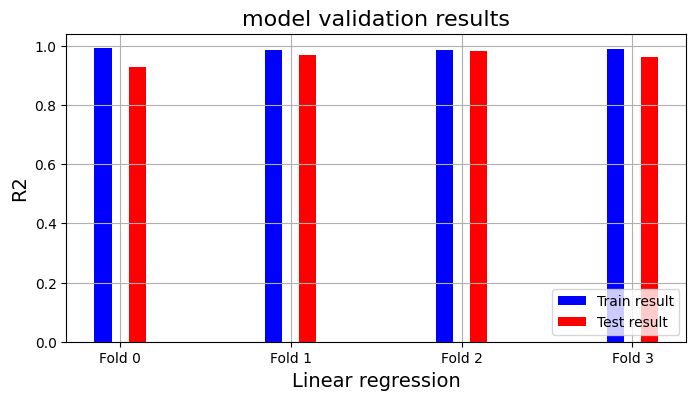

In [10]:
fold=4
cv = ShuffleSplit(n_splits=fold, test_size=.25, random_state=123)

cross_results= cross_validate(estimator=model_linear, X=data_x, y=data_y, cv=cv, scoring=['r2'],return_train_score=True)
print(cross_results)

x_labels = [f"Fold {i}" for i in range(fold)]
label1='Train result'
label2='Test result'
plot_result("Linear regression","R2","model validation results", cross_results['train_r2'],cross_results['test_r2'],len(x_labels),x_labels,label1,label2)

### Create training and test dataset for comparing the performance of different models 

In [11]:
#Split the dataset into two subset, train subset and test subtset
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y)

MSE: 140403.9100664937
RMSE: 374.7050974653183
Mean absolute error 293.4181511079557
R2: 0.9713089831302408


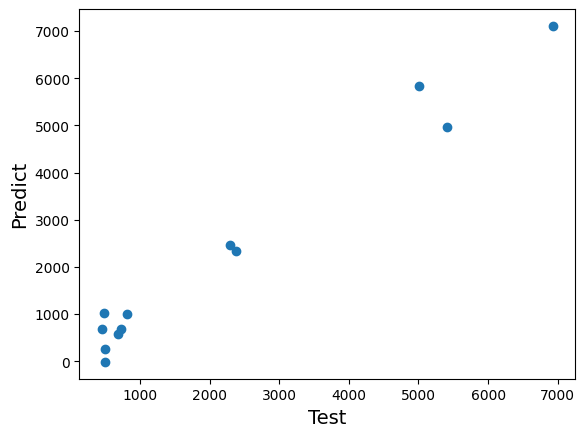

In [12]:
#Train and evaluate the model
model_linear.fit(x_train,y_train)
y_predict_linear = model_linear.predict(x_test)
regression_evaluation(y_test, y_predict_linear)

### Interpret linear model

In [13]:
model_linear[1].coef_, model_linear[1].intercept_

(array([  949.55310247,    35.00637815,  -439.22104923,  -945.56210059,
         -409.16206138,   897.05763322,  1339.34704107,  1107.80289769,
           12.74997179, -1307.11908756, -1142.13045893,   -98.32226671,
         -182.17335608]),
 14417.741854855787)

In [14]:
#Interpret prediction
for index, row in x_test.iterrows():
    score=model_linear[1].intercept_+model_linear[1].coef_[int(row["month"])-1]+model_linear[1].coef_[-1]*row["temperature"]
    print(row["temperature"],row["month"],score)

79.57632258064515 8.0 1028.8590039200717
45.33451612903225 1.0 7108.554008057845
60.0674 11.0 2332.9315472232374
79.2956 9.0 -15.053747339454276
51.39529032258065 12.0 4956.56706362863
82.76638709677418 7.0 679.2583882994004
73.1589565219355 5.0 680.967156927547
66.5112258064516 10.0 994.0495454654265
52.27496774193548 1.0 5844.188645058532
73.724 5.0 578.031290200197
82.59914545466667 6.0 267.43595166453633
63.26135483870968 3.0 2453.9874847988867


### Predict demand in 2017

In [15]:
df_2017=df_total[df_total['year']==2017][["temperature","month"]]
y_predict_linear_2017 = model_linear.predict(df_2017)
df_2017, y_predict_linear_2017

(    temperature  month
 48    54.166710      1
 49    57.679571      2
 50    57.879935      3,
 array([5499.56366784, 3945.06712889, 3434.33870912]))

## 2. GradientBoostingRegressor

### Build the model 

In [16]:
model_gbr = make_pipeline(preprocessor, GradientBoostingRegressor(n_estimators=500,learning_rate=0.01,subsample=.5,max_depth=1,random_state=1))
model_gbr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['month'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=1,
                                           n_estimators=500, random_state=1,
                                           subsample=0.5))])

### Cross validate the model

{'fit_time': array([0.28089571, 0.24724174, 0.23299861, 0.23414564]), 'score_time': array([0.00343323, 0.00338864, 0.00320697, 0.00341153]), 'test_r2': array([0.955493  , 0.97105075, 0.99302008, 0.94270768]), 'train_r2': array([0.99095581, 0.99021342, 0.98746773, 0.99363868])}


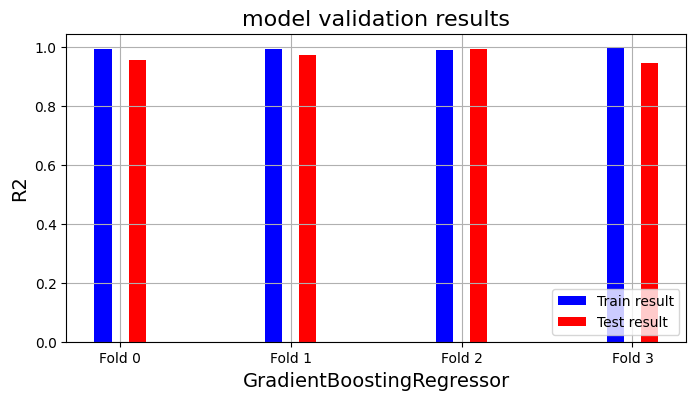

In [17]:
cross_results= cross_validate(estimator=model_gbr, X=data_x, y=data_y, cv=cv, scoring=['r2'],return_train_score=True)
print(cross_results)

plot_result("GradientBoostingRegressor","R2","model validation results", cross_results['train_r2'],cross_results['test_r2'],len(x_labels),x_labels,label1,label2)

### Training and test the model using the same dataset created above

MSE: 97691.83387035494
RMSE: 312.5569290071089
Mean absolute error 218.85896646647734
R2: 0.9800370370576955


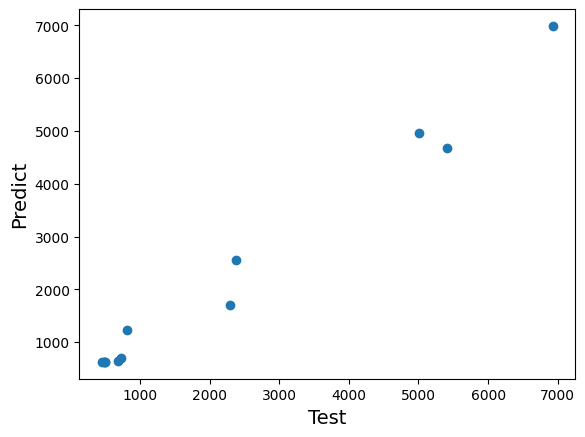

In [18]:
model_gbr.fit(x_train,y_train)
y_predict_gbr = model_gbr.predict(x_test)
regression_evaluation(y_test, y_predict_gbr)

In [19]:
y_predict_gbr_2017 = model_gbr.predict(df_2017)
df_2017, y_predict_gbr_2017

(    temperature  month
 48    54.166710      1
 49    57.679571      2
 50    57.879935      3,
 array([4366.46066936, 2894.38085792, 2853.8247816 ]))

## 3. Compare prediction on both models for test year

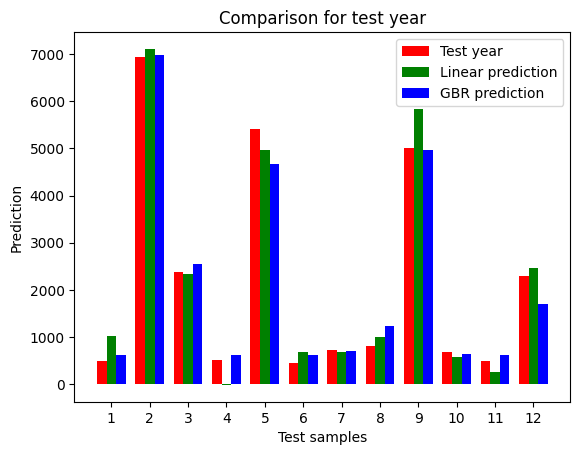

In [20]:
month = [i for i in range(1,13)]
ind = np.arange(len(y_test.values)) 
width = 0.25
  
bar1 = plt.bar(ind, y_test.values, width, color = 'r')
  
bar2 = plt.bar(ind+width, y_predict_linear, width, color='g')
  
bar3 = plt.bar(ind+width*2, y_predict_gbr, width, color = 'b')
  
plt.xlabel("Test samples")
plt.ylabel('Prediction')
plt.title("Comparison for test year")
  
plt.xticks(ind+width,month)
plt.legend( (bar1, bar2, bar3), ('Test year', 'Linear prediction', 'GBR prediction') )
plt.show()

## 4. Compare prediction for 2017

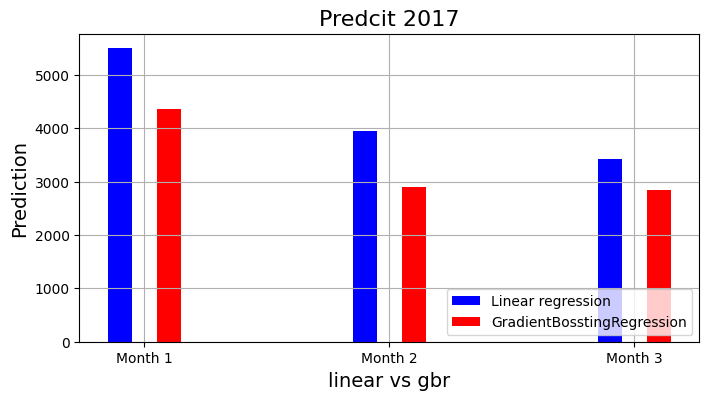

In [21]:
x_labels = [f"Month {i}" for i in range(1,4)]
label1='Linear regression'
label2='GradientBosstingRegression'
plot_result("linear vs gbr","Prediction","Predcit 2017", y_predict_linear_2017,y_predict_gbr_2017,len(x_labels),x_labels,label1,label2)

# 2. Interplate daily demand
In this task, linear programming algorithm is applied to build a linear regression model to make daily prediction.

## Build interplate model using linear programming algorithm

In [22]:
def build_daily_model(year, month):
    df_month=df_temperature_daily[(df_temperature_daily["year"]==year) & (df_temperature_daily["month"]==month)]
    monthly_demand=(df_demand.loc[(df_demand["year"]==year) & (df_demand["month"]==month)]["demand"]).values[0]
    model = Model('daily demand')
    total_temperature=df_month["temperature"].sum()
    #Set min daily demand to be 70% of average daily demand of that month
    min_daily_demand=monthly_demand/len(df_month)*0.6
    corr_lowbound=-5000
    corr_upperbound=5000
    param_num=2
    x = {}
    for i in range(param_num):
        x[i] = model.addVar(lb = corr_lowbound, ub = corr_upperbound, vtype = GRB.CONTINUOUS, name = 'x_' + str(i))

    obj = len(df_month)*x[0]+total_temperature*x[1]   
    model.setObjective(obj, GRB.MAXIMIZE)

    model.addConstr(obj <= monthly_demand, name = 'obj_upbound')
    
    for index, row in df_month.iterrows():
        daily_demand = x[0]+x[1]*row["temperature"]
        model.addConstr(daily_demand >= min_daily_demand, name = f'cons_lowbound{index}')
    model.optimize()

    # print the obj result
    print('Obj = ', model.ObjVal)
    
    intercept=x[0].x
    coef_temp=x[1].x
    
    return intercept, coef_temp


intercept, coef_temp=build_daily_model(2013,1)

intercept, coef_temp

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 32 rows, 2 columns and 64 nonzeros
Model fingerprint: 0x78b04433
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+01, 2e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [1e+02, 5e+03]
Presolve removed 32 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0030000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.003000000e+03
Obj =  5003.000000000559


(350.67975890772504, -3.6210957234443413)

In [23]:
#TODO for debug
#df_temperature_daily["demand"]=intercept+coef_temp*df_temperature_daily["temperature"]

In [24]:
#Interplate daily demand using the model built by linear programming
for year in range(2013,2017):
    for month in range(1,13):
        intercept, coef_temp=build_daily_model(year,month)
        df_temperature_daily.loc[(df_temperature_daily["year"]==year) & (df_temperature_daily["month"]==month),"demand"]=intercept+coef_temp*df_temperature_daily["temperature"]

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 32 rows, 2 columns and 64 nonzeros
Model fingerprint: 0x78b04433
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+01, 2e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [1e+02, 5e+03]
Presolve removed 32 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0030000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.003000000e+03
Obj =  5003.000000000559
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 l


CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 2 columns and 62 nonzeros
Model fingerprint: 0x9c1d5787
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+01, 2e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [7e+01, 4e+03]
Presolve removed 31 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6510000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.651000000e+03
Obj =  3650.999999999349
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 2 columns and 62 nonzeros
Model fingerprint: 0x9edaada6
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+01, 2e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [1e+01, 5e+02]
Presolve removed 31 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.900000000e+02
Obj =  489.99999999896204
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 32 rows, 2 columns and 64 nonzeros
Model fingerprint: 0x19038791
Coefficient sta


Optimize a model with 32 rows, 2 columns and 64 nonzeros
Model fingerprint: 0xd9126d00
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [3e+01, 3e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [1e+01, 5e+02]
Presolve removed 32 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0200000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.020000000e+02
Obj =  501.9999999994152
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 32 rows, 2 columns and 64 nonzeros
Model fingerprint: 0x0062af5d
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [3e+01, 3e+03]
  

Model fingerprint: 0xd047fc49
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+01, 2e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [1e+01, 7e+02]
Presolve removed 32 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2300000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.230000000e+02
Obj =  722.9999999991287
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 2 columns and 62 nonzeros
Model fingerprint: 0xbf5fbac6
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+01, 2e+03]
  Bounds range     [5e+03, 5e+03]
  RHS range        [1e+01,

## Plot interplate results

<AxesSubplot:>

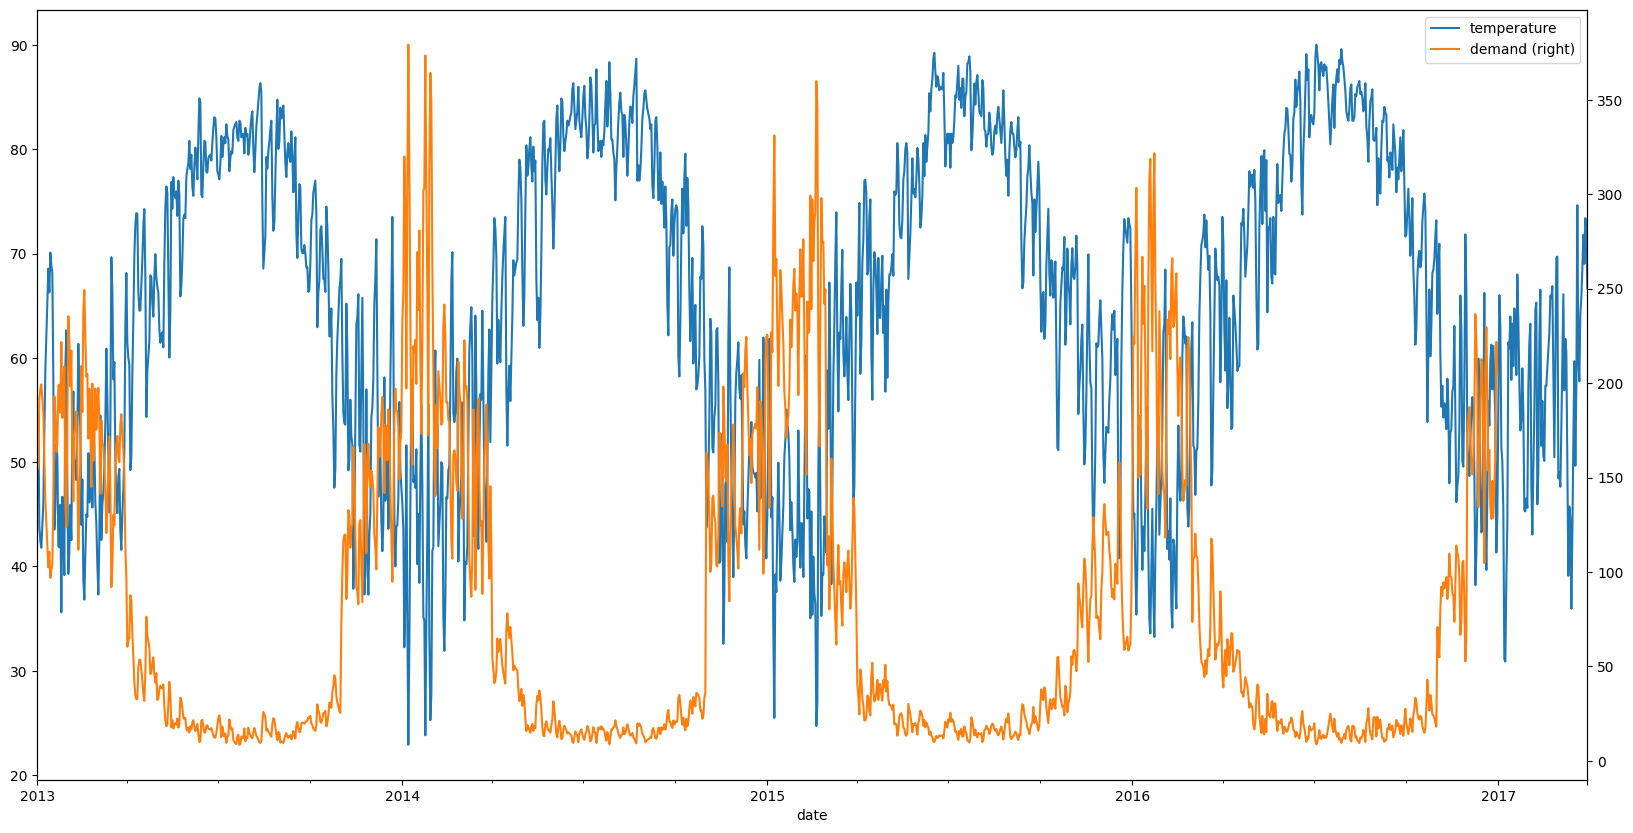

In [25]:
df_plot=df_temperature_daily
fig, ax = plt.subplots(figsize=(20,10)) 
df_plot.plot(x='date', y=['temperature'], ax = ax)
df_plot.plot(x = 'date', y = 'demand', ax = ax, secondary_y = True) 

## Compare aggregated interplating demand with real monthly demand

In [26]:
predicted_agg_demand=df_temperature_daily[df_temperature_daily['year']<=2016].groupby(['year','month']).sum()["demand"].values
predicted_agg_demand

array([5003., 5216., 4751., 1586.,  824.,  497.,  440.,  487.,  472.,
        815., 3651., 4901., 8096., 4995., 4487., 1580.,  676.,  472.,
        453.,  476.,  490.,  836., 4224., 5119., 6930., 7065., 3183.,
       1066.,  687.,  496.,  502.,  513.,  549., 1032., 2374., 3019.,
       6899., 5713., 2293., 1408.,  723.,  502.,  450.,  487.,  504.,
        733., 2633., 5410.])

In [27]:
origin_monthly_demand=df_demand["demand"].values
origin_monthly_demand

array([5003, 5216, 4751, 1586,  824,  497,  440,  487,  472,  815, 3651,
       4901, 8096, 4995, 4487, 1580,  676,  472,  453,  476,  490,  836,
       4224, 5119, 6930, 7065, 3183, 1066,  687,  496,  502,  513,  549,
       1032, 2374, 3019, 6899, 5713, 2293, 1408,  723,  502,  450,  487,
        504,  733, 2633, 5410])

MSE: 3.363334861708519e-19
RMSE: 5.799426576575066e-10
Mean absolute error 5.344927463587131e-10
R2: 1.0


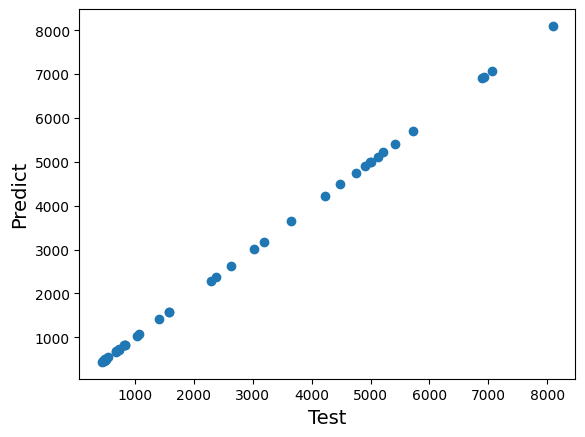

In [28]:
regression_evaluation(origin_monthly_demand, predicted_agg_demand)